In [148]:
%load_ext autoreload
%autoreload 2

import sys, os
import lightning.pytorch as pl
import torch
from matplotlib import pyplot as plt
import numpy as np
import pickle
from itertools import product, combinations_with_replacement
from skimage.morphology import disk, remove_small_objects
from skimage.measure import label, regionprops
from tqdm import tqdm
import pandas as pd 
from collections import defaultdict
import glob

sys.path.insert(1, sys.path[0] + '/..')
from src.data.datamodule import DataModule
from src.data.utils import simplify_labels
from src.model.setup import setup_model
from src.misc.utils import set_seed_and_precision
from src.misc.files import SetupArgs, read_image
from src.misc.post import calculate_metrics
from src.postprocess import _remove_low_probs, _remove_spine_fp, _remove_small_objects, _post_process
from src.postprocess import main as postprocess_main, parse_option as postprocess_parse_option

from src.run import parse_option, main
args = parse_option(notebook=True)
args.data_dir = '../data_dev'
args.version = 'version_sam'
args.version = 'version_elias'
args.num_workers = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Train

In [149]:
args.train, args.predict = False, True
args.splits = ['train']

postprocess_args = postprocess_parse_option(notebook=True)
postprocess_args.split = args.splits[0]
postprocess_args.prediction_box_dir = os.path.join(args.log_dir, args.net, args.version, 'segmentations')
postprocess_args.original_image_dir = args.data_dir
postprocess_args.save_dir = os.path.join(args.log_dir, 'submissions', args.version, postprocess_args.split)


In [150]:
img_ids = os.listdir(os.path.join(postprocess_args.prediction_box_dir, postprocess_args.split))
img_id = img_ids[0]

In [151]:
def get_boxes(boxes_dir):
    return [np.load(filename)['arr_0'] for filename in glob.iglob(boxes_dir + '**/**/*.npz', recursive=True)]

In [152]:
y_true = get_boxes(os.path.join(postprocess_args.original_image_dir, 'boxes', postprocess_args.split, 'labels'))
x      = get_boxes(os.path.join(postprocess_args.original_image_dir, 'boxes', postprocess_args.split, 'images'))
y_pred = get_boxes(os.path.join(postprocess_args.prediction_box_dir, postprocess_args.split))

In [153]:
data = []
for i, j, k in zip(x, y_true, y_pred):
    s = np.array(i.shape)
    idxs = tuple([slice(0, s_i) for s_i in i.shape])
    data.append( np.stack([i, j, k[idxs]], axis=0) )

(array([     0.,      0.,      0.,      0.,      0., 262144.,      0.,
             0.,      0.,      0.]),
 array([0.02162647, 0.12162647, 0.22162648, 0.32162648, 0.42162648,
        0.52162647, 0.6216265 , 0.72162646, 0.82162648, 0.92162645,
        1.02162647]),
 <BarContainer object of 10 artists>)

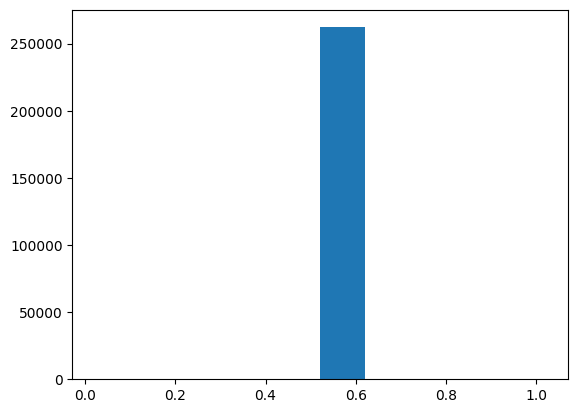

In [161]:
plt.hist(y_pred[0].flatten() )

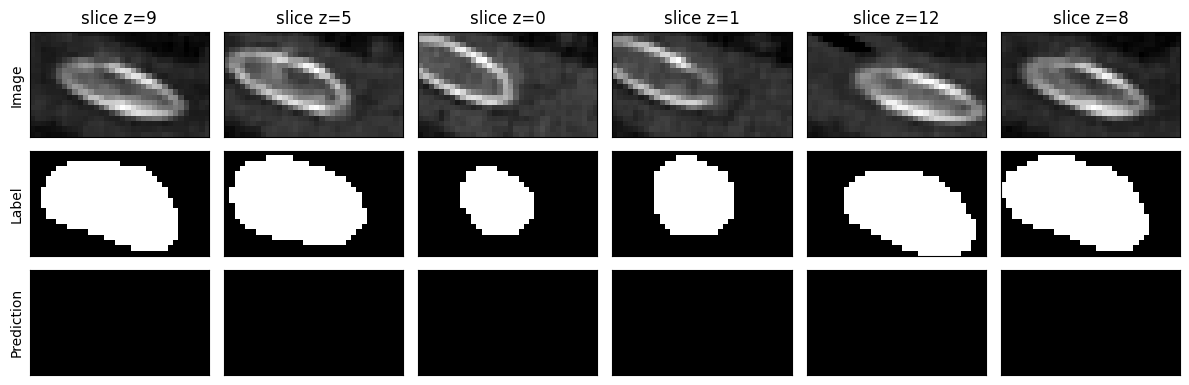

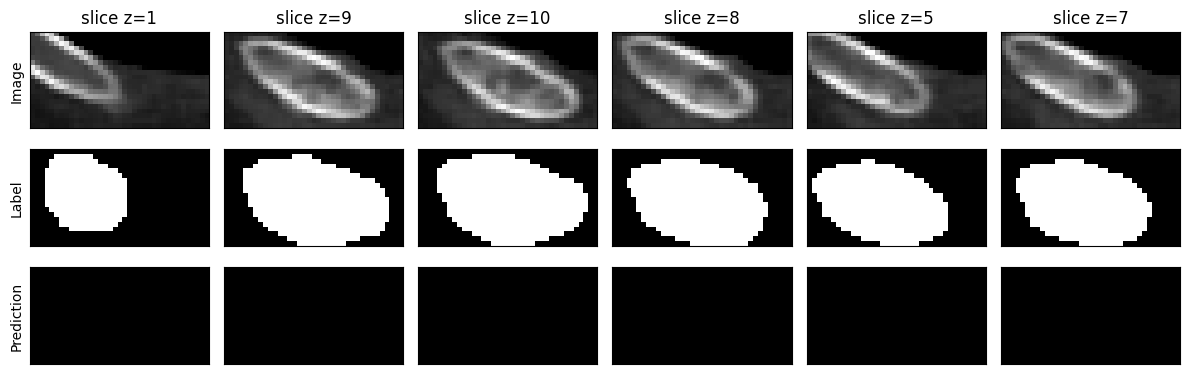

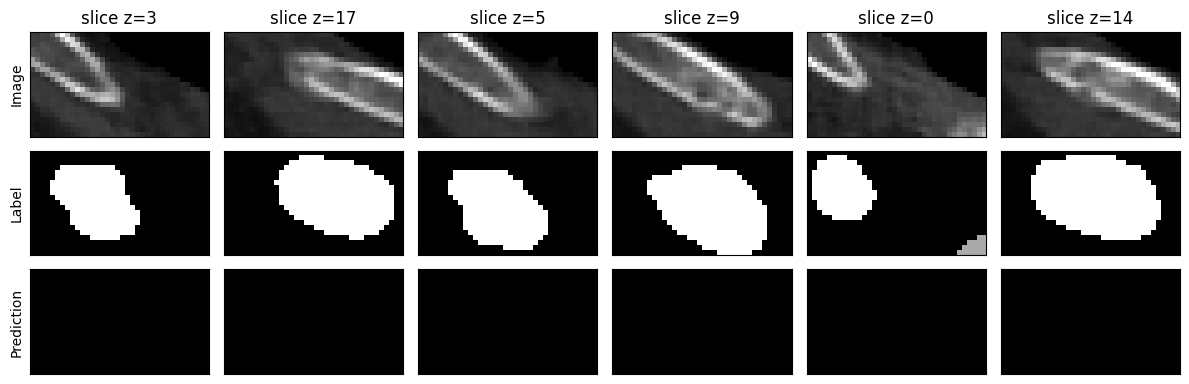

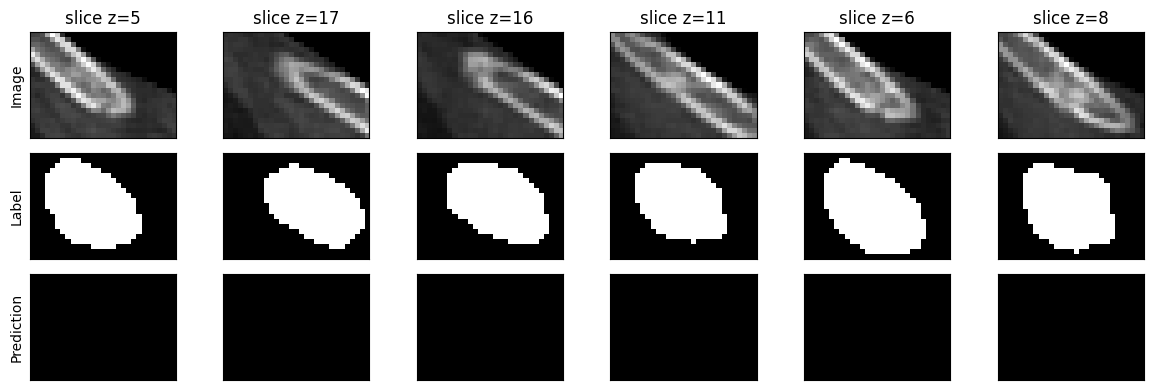

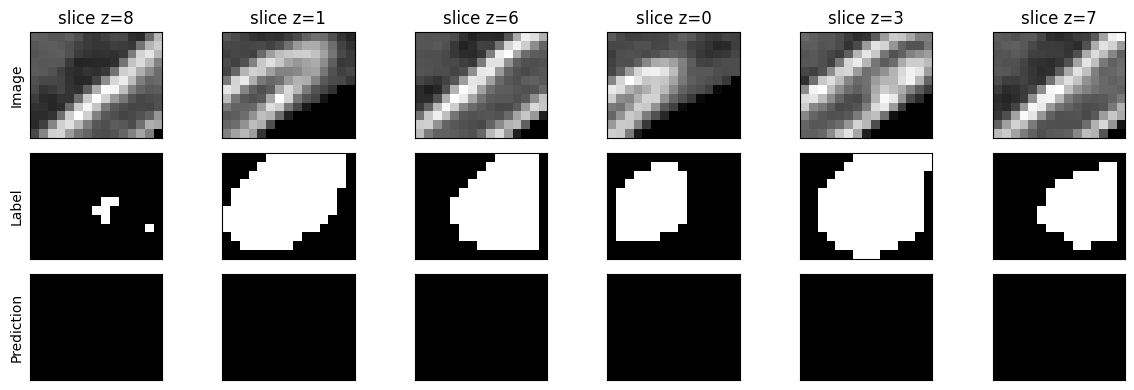

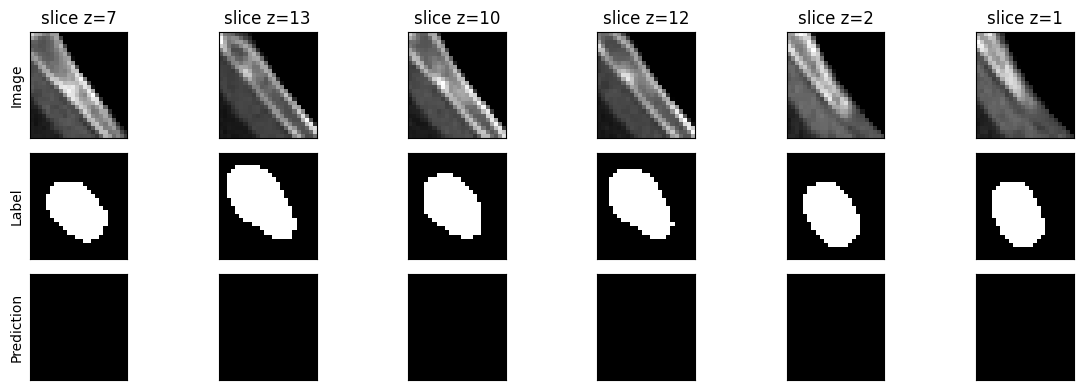

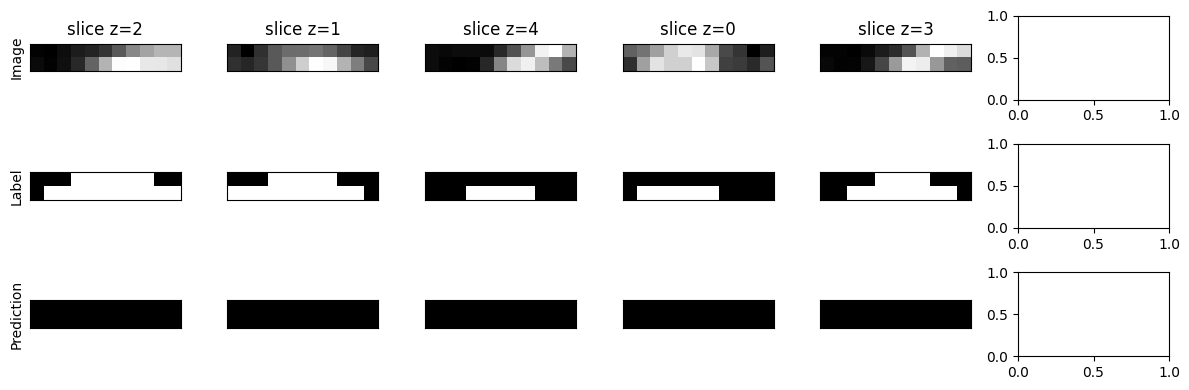

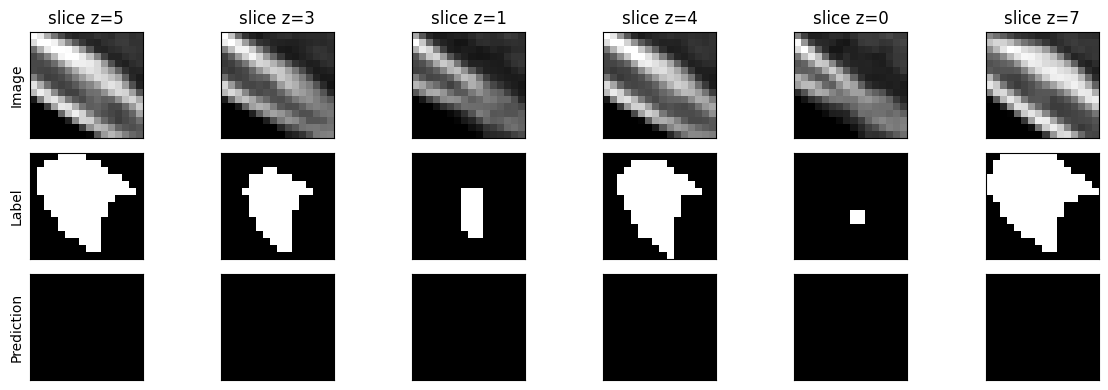

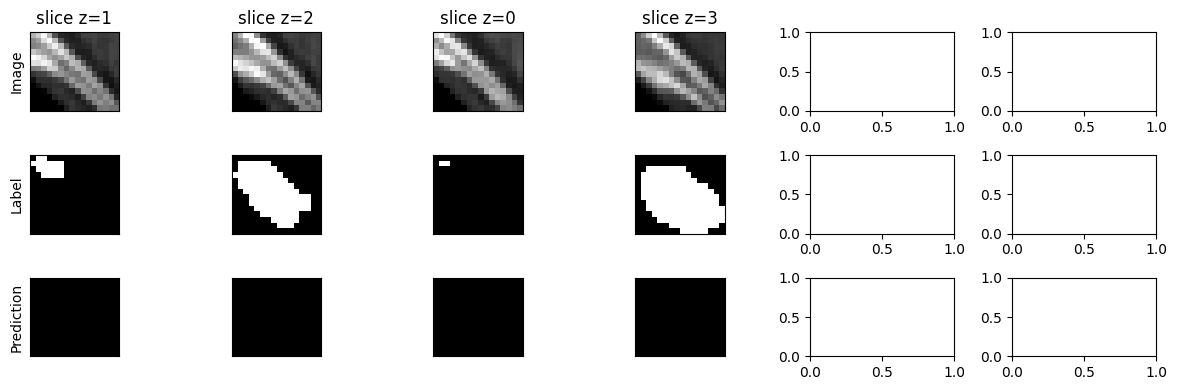

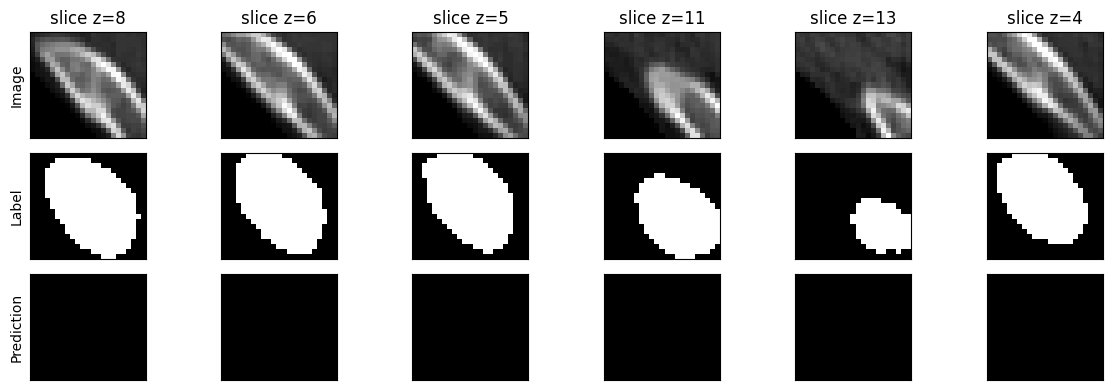

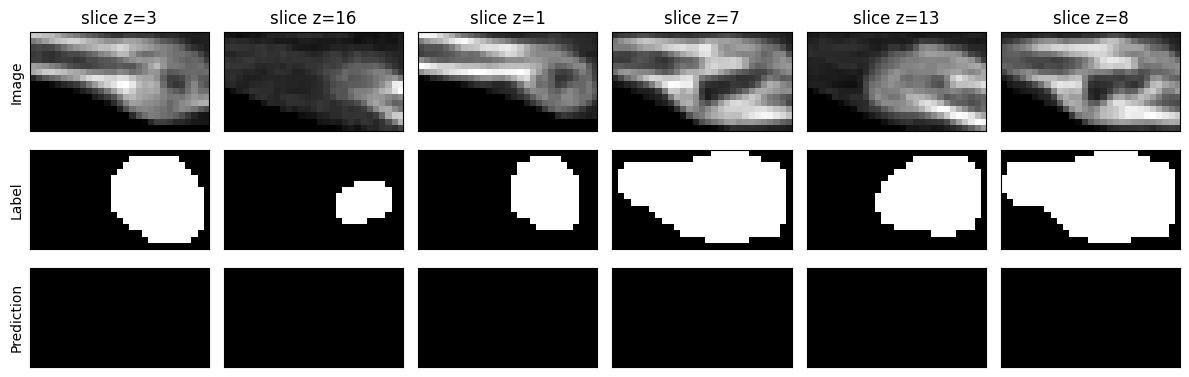

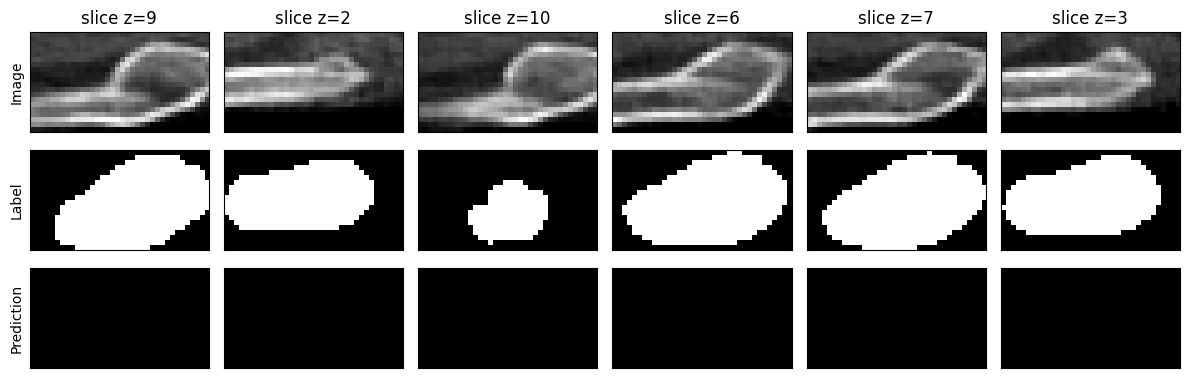

In [154]:
for d in data:

    zs = d.shape[-1]
    n = 6
    fig, axs = plt.subplots(len(d), n, figsize=(2*n, 4), tight_layout=True)
    titles = ['Image', 'Label', 'Prediction']
    zs_arr = np.arange(zs)
    np.random.shuffle(zs_arr)
    zs_arr = zs_arr[:n]
    for i in range(len(titles)):
        axs[i, 0].set_ylabel(titles[i])
    for j, z in enumerate(zs_arr):
        axs_i = axs[:, j]
        for i, ax in enumerate(axs_i):
            ax.imshow(d[i][:, :, z], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        axs_i[0].set_title(f'slice z={z}')

    plt.show()


Analysis

NameError: name 'gs' is not defined

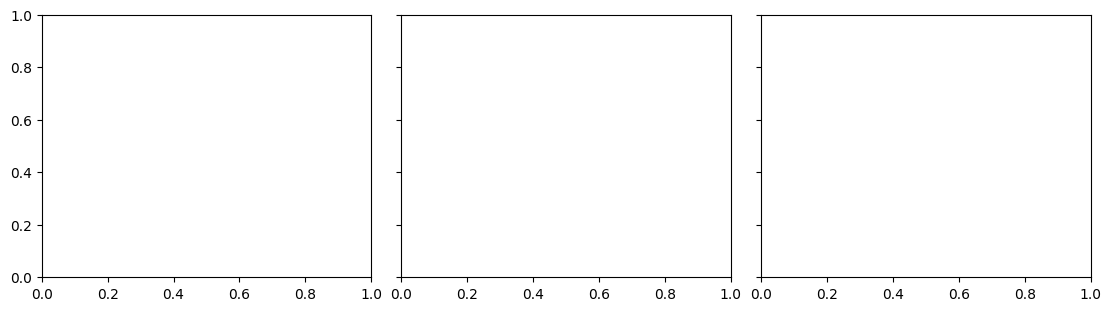

In [155]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    ax = axs[i]
    im = ax.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    fig.colorbar(im, ax=ax)
    ax.set_title(metric)
    ax.set_xscale('log')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()
    


In [ ]:
# find indecies where recall is max
gs[gs['recall_mean'] == gs['recall_mean'].max()]

,Unnamed: 0,prob_thresh,bone_thresh,size_thresh,accuracy,precision,recall,accuracy_mean,precision_mean,recall_mean,accuracy_std,precision_std,recall_std
0,0,0.000000,200.0,0.000000,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
1,1,0.000000,200.0,555.555556,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
2,2,0.000000,200.0,1111.111111,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
10,10,0.001000,200.0,0.000000,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
11,11,0.001000,200.0,555.555556,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
12,12,0.001000,200.0,1111.111111,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
20,20,0.002371,200.0,0.000000,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
21,21,0.002371,200.0,555.555556,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
22,22,0.002371,200.0,1111.111111,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0
30,30,0.005623,200.0,0.000000,[0.9995083808898926],[0.32533136010169983],[1.0],0.999508,0.325331,1.0,0.0,0.0,0.0


### Old analysis

In [ ]:
assert False

AssertionError: 

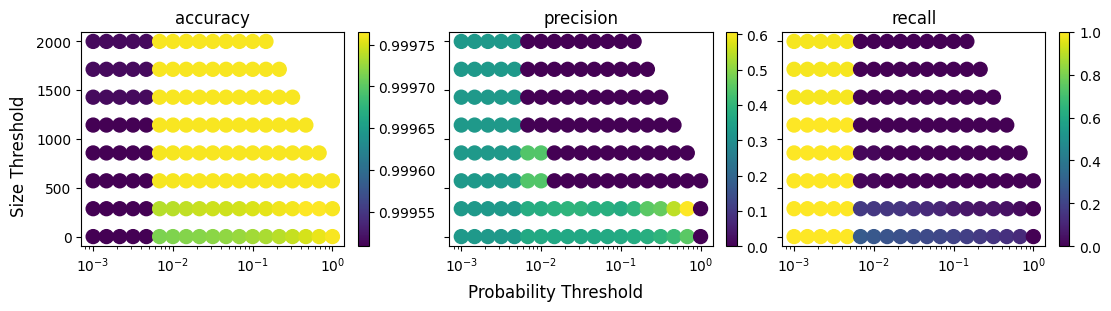

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    ax = axs[i]
    im = ax.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    fig.colorbar(im, ax=ax)
    ax.set_title(metric)
    ax.set_xscale('log')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()
    


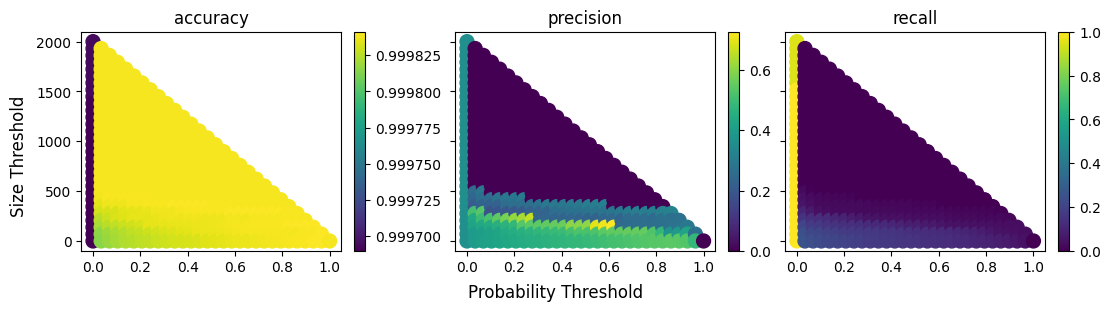

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    ax = axs[i]
    im = ax.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    fig.colorbar(im, ax=ax)
    ax.set_title(metric)
    # ax.set_xscale('log')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()

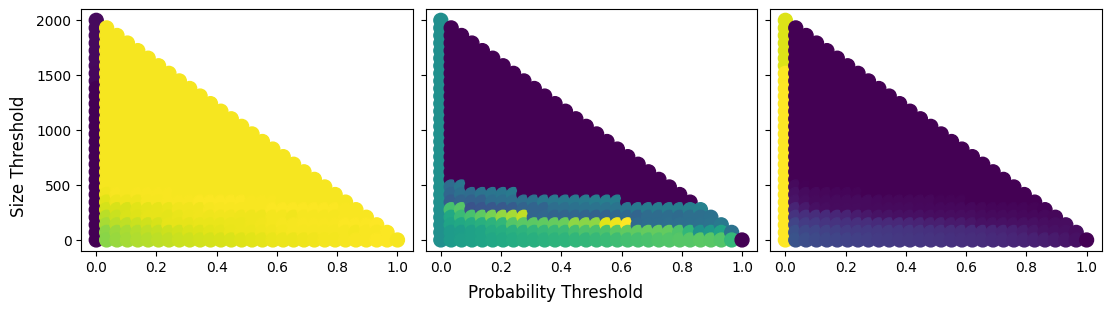

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    axs[i].scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    # axs[i].set_xscale('log')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()
    


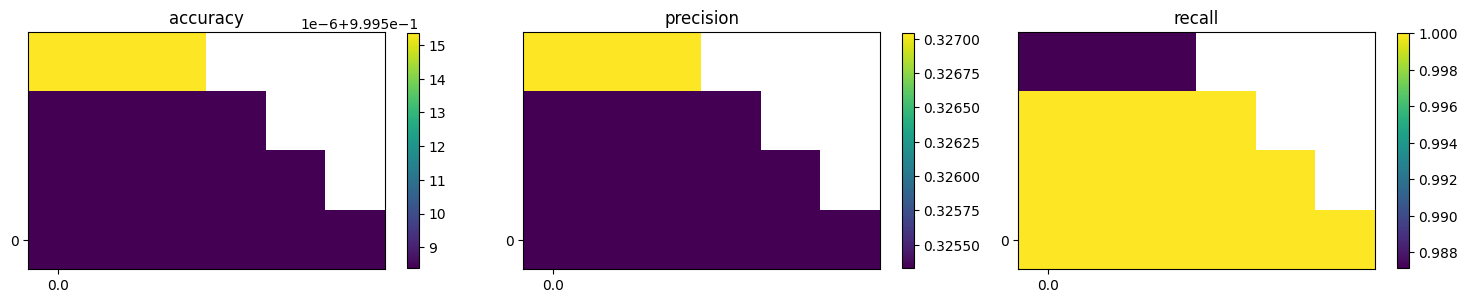

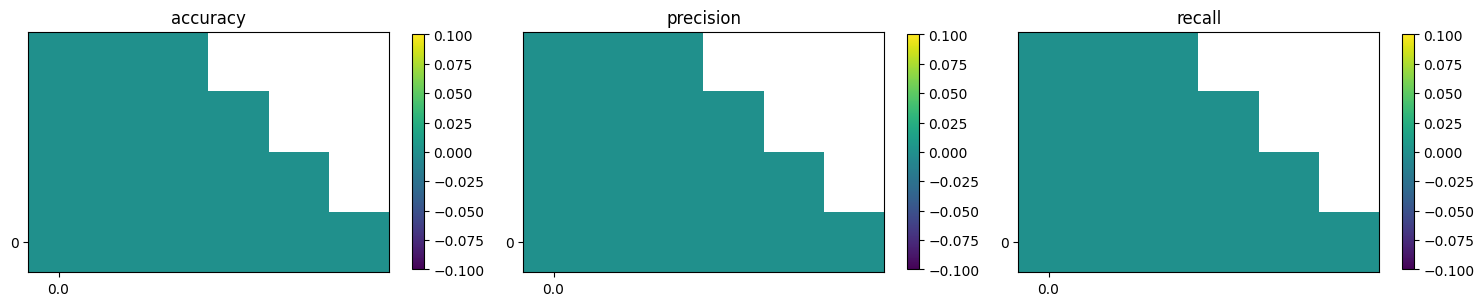

In [ ]:
metric_stats = ['mean', 'std']
for metric_stat in metric_stats:
    prob_thresh_values = gs['prob_thresh'].unique()
    size_thresh_values = gs['size_thresh'].unique()

    metrics = {k : np.zeros((len(prob_thresh_values), len(size_thresh_values))) for k in ['accuracy', 'precision', 'recall']}

    for i , prob_thresh_value in enumerate(prob_thresh_values):
        for j, size_thresh_value in enumerate(size_thresh_values):
            x = gs[(gs['prob_thresh'] == prob_thresh_value) & (gs['size_thresh'] == size_thresh_value)]
            if len(x) == 0:
                metrics['accuracy'][i, j] = np.nan
                metrics['precision'][i, j] = np.nan
                metrics['recall'][i, j] = np.nan
            else:
                metrics['accuracy'][i, j] = x.iloc[0][f'accuracy_{metric_stat}']
                metrics['precision'][i, j] = x.iloc[0][f'precision_{metric_stat}']
                metrics['recall'][i, j] = x.iloc[0][f'recall_{metric_stat}']

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

    for i, metric in enumerate(['accuracy', 'precision', 'recall']):
        ax = axs[i]
        cmap = ax.imshow(metrics[metric].T, cmap = 'viridis', origin='lower')
        fig.colorbar(cmap, ax=ax, shrink=0.5)

        ii = 6
        ax.set_yticks(np.arange(len(size_thresh_values))[::ii])
        ax.set_xticks(np.arange(len(prob_thresh_values))[::ii])
        # ax.set_yticks(np.linspace(0, len(size_thresh_values), ii, dtype=int, endpoint=True))
        # ax.set_xticks(np.linspace(0, len(prob_thresh_values), ii, dtype=int, endpoint=True))
        ax.set_yticklabels(np.round(size_thresh_values).astype(int)[::ii])
        ax.set_xticklabels(np.round(prob_thresh_values, 2)[::ii])
        # ax.set_yticklabels(np.linspace(0, size_thresh_values.max(), ii, dtype=int, endpoint=True))
        # ax.set_xticklabels(np.round(np.logs(0, prob_thresh_values.max(), ii, endpoint=True), 2))
        ax.set_title(metric)
    # fig.supylabel('Size Threshold')
    # fig.supxlabel('Probability Threshold')
    plt.show()

### Continue analysis

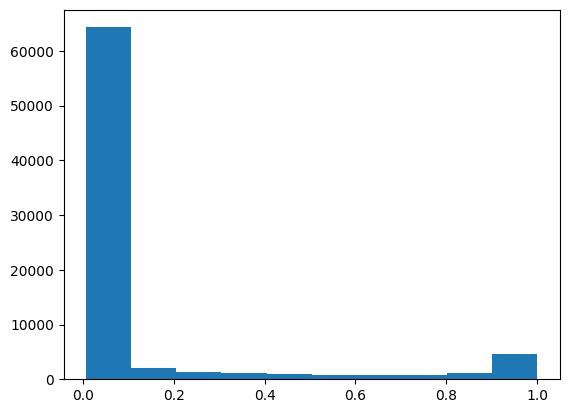

In [ ]:
plt.hist(y_pred_nonzero)
plt.show()